In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from openslide import OpenSlide

In [3]:
slide_list = {path.name: OpenSlide(str(path)) for path in tqdm(Path(r"D:\Datasets\ColonCancer").glob("*/*/*.tif"))}

slide_list

20it [00:01, 13.41it/s]


{'CRC-A1-1 HE.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\HE\\CRC-A1-1 HE.tif'),
 'CRC-A1-10 HE.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\HE\\CRC-A1-10 HE.tif'),
 'CRC-A1-13 HE.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\HE\\CRC-A1-13 HE.tif'),
 'CRC-A1-2 HE.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\HE\\CRC-A1-2 HE.tif'),
 'CRC-A1-5 HE.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\HE\\CRC-A1-5 HE.tif'),
 'CRC-A1-1.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\IHC\\CRC-A1-1.tif'),
 'CRC-A1-10.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\IHC\\CRC-A1-10.tif'),
 'CRC-A1-13.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\IHC\\CRC-A1-13.tif'),
 'CRC-A1-2.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\IHC\\CRC-A1-2.tif'),
 'CRC-A1-5.tif': OpenSlide('D:\\Datasets\\ColonCancer\\MultiSlide\\IHC\\CRC-A1-5.tif'),
 'CRC-AI-11 F X40.tif': OpenSlide('D:\\Datasets\\ColonCancer\\SingleSlide\\HE\\CRC-AI-1

In [4]:
coordinates = {
    "L0": (0, 0), 
    "L1": (1, 0), 
    "L2": (2, 0), 
    "L3": (3, 0),   
    "L4": (4, 0),
    
    "L5": (0, 1),
    "L6": (1, 1),
    "L7": (2, 1),
    "L8": (3, 1),    
    "L9": (4, 1),
    
    "L10": (0, 2),
    "L11": (1, 2),
    "L12": (2, 2),
    "L13": (3, 2),    
    "L14": (4, 2),
    
    "L15": (0, 3),
    "L16": (1, 3),
    "L17": (2, 3),
    "L18": (3, 3),    
    "L19": (4, 3),
    
    "L20": (0, 4),
    "L21": (1, 4),
    "L22": (2, 4),
    "L23": (3, 4),    
    "L24": (4, 4),
}

In [5]:
def add_help_fields(frame):
    
    frame["image_name_stem"] = [Path(image_name).stem for image_name in frame["image_name"]]
    
    frame["patient_id"] = [name.split("-")[2].replace("40X", "X40").split(" X40")[0].replace(" HE", "").replace(".tif", "") for name in frame["image_name"]]

    frame["x1"] = [json.loads(vector.replace("\'","\""))['x1'] for vector in frame["vector"]]
    frame["y1"] = [json.loads(vector.replace("\'","\""))['y1'] for vector in frame["vector"]]

    frame["x2"] = [json.loads(vector.replace("\'","\""))['x2'] for vector in frame["vector"]]
    frame["y2"] = [json.loads(vector.replace("\'","\""))['y2'] for vector in frame["vector"]]

    frame["center_x"] = [x1 + ((x2-x1) / 2) for x1, x2 in zip(frame["x1"], frame["x2"])]
    frame["center_y"] = [y1 + ((y2-y1) / 2) for y1, y2 in zip(frame["y1"], frame["y2"])]
    
    frame["center"] = [np.array((center_x, center_y)) for center_x, center_y in zip(frame["center_x"], frame["center_y"])]

    frame["anno_width"] = [x2-x1 for x1, x2 in zip(frame["x1"], frame["x2"])]
    frame["anno_height"]= [y2-y1 for y1, y2 in zip(frame["y1"], frame["y2"])]
    
    return frame

In [6]:
gt_annotations = add_help_fields(pd.read_csv("GT_D240.csv"))
gt_annotations.head()

scanner  image_id         image_name image_type  image_width  image_height  \
0      HE       325  CRC-AI-15 40X.tif        RSC        86256         86432   
1      HE       325  CRC-AI-15 40X.tif        RSC        86256         86432   
2      HE       325  CRC-AI-15 40X.tif        RSC        86256         86432   
3      HE       325  CRC-AI-15 40X.tif        RSC        86256         86432   
4      HE       325  CRC-AI-15 40X.tif        RSC        86256         86432   

      id                                             vector  \
0  26106   {'x1': 4236, 'x2': 4434, 'y1': 8043, 'y2': 8241}   
1  26107  {'x1': 6352, 'x2': 6552, 'y1': 23748, 'y2': 23...   
2  26108  {'x1': 6158, 'x2': 6358, 'y1': 38586, 'y2': 38...   
3  26109  {'x1': 11860, 'x2': 12060, 'y1': 52464, 'y2': ...   
4  26110  {'x1': 6827, 'x2': 7025, 'y1': 68732, 'y2': 68...   

                      unique_identifier  annotation_type  ... patient_id  \
0  f52b1e31-3df8-4041-9902-66bc6edef761               21  ...         15   
1  b8ca1cea-38ef-4818-b050-d77ef0e44e21               22  ...         15   
2  9d817eda-dd12-49b4-a942-9d7ddd77f305               23  ...         15   
3  04454db4-2e29-4e18-8f8e-271d8e154507               24  ...         15   
4  81ee0679-7857-4fc4-a402-df65b0576831               25  ...         15   

      x1     y1     x2     y2  center_x  center_y              center  \
0   4236   8043   4434   8241    4335.0    8142.0    [4335.0, 8142.0]   
1   6352  23748   6552  23948    6452.0   23848.0   [6452.0, 23848.0]   
2   6158  38586   6358  38786    6258.0   38686.0   [6258.0, 38686.0]   
3  11860  52464  12060  52664   11960.0   52564.0  [11960.0, 52564.0]   
4   6827  68732   7025  68934    6926.0   68833.0   [6926.0, 68833.0]   

   anno_width anno_height  
0         198         198  
1         200         200  
2         200         200  
3         200         200  
4         198         202  

[5 rows x 22 columns]

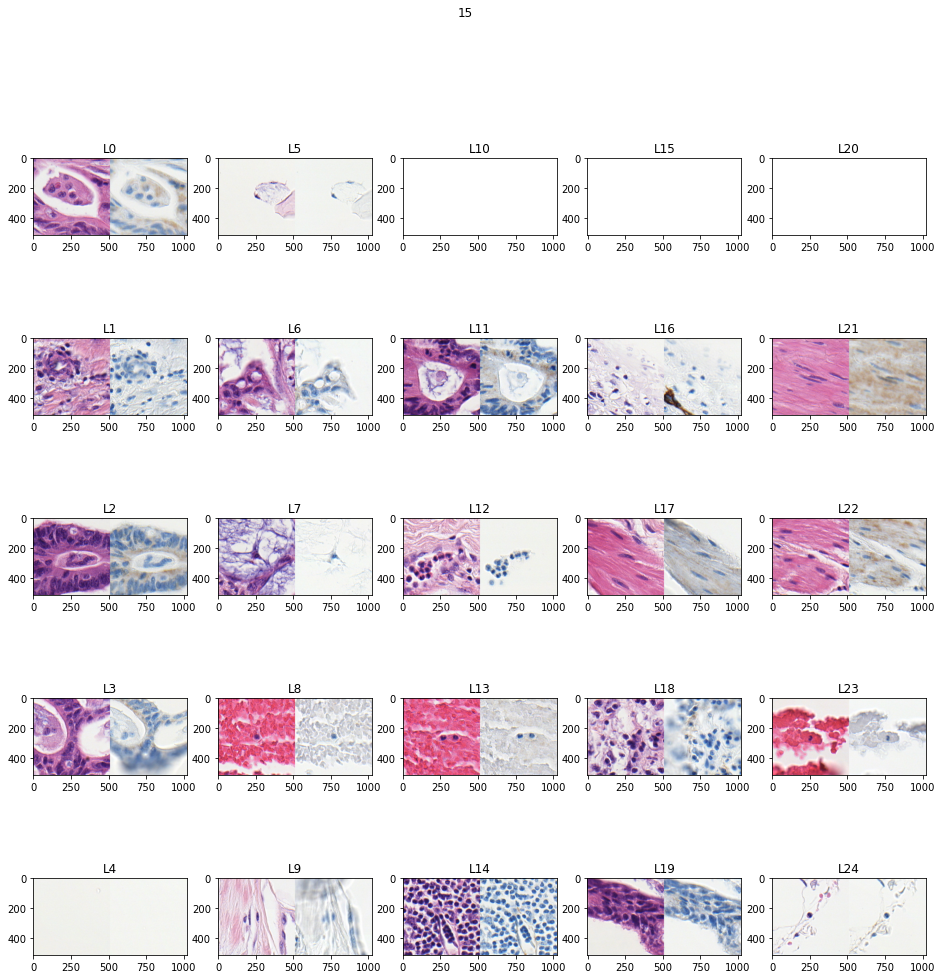

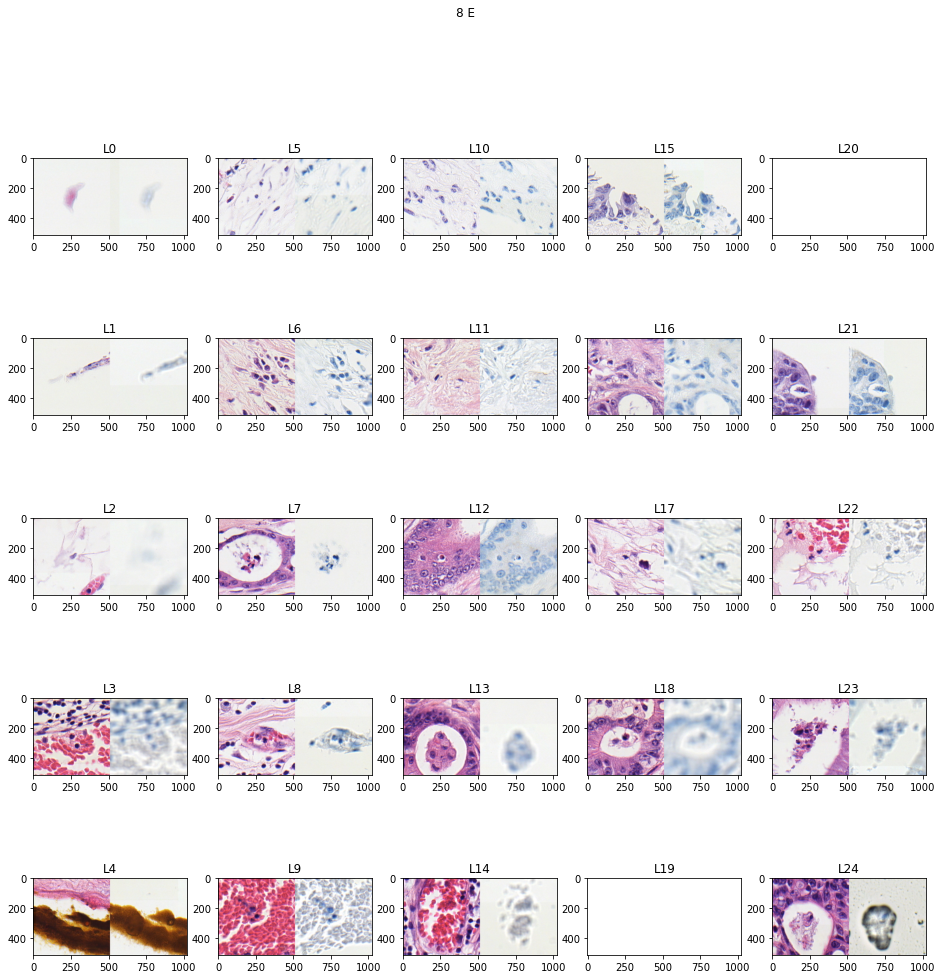

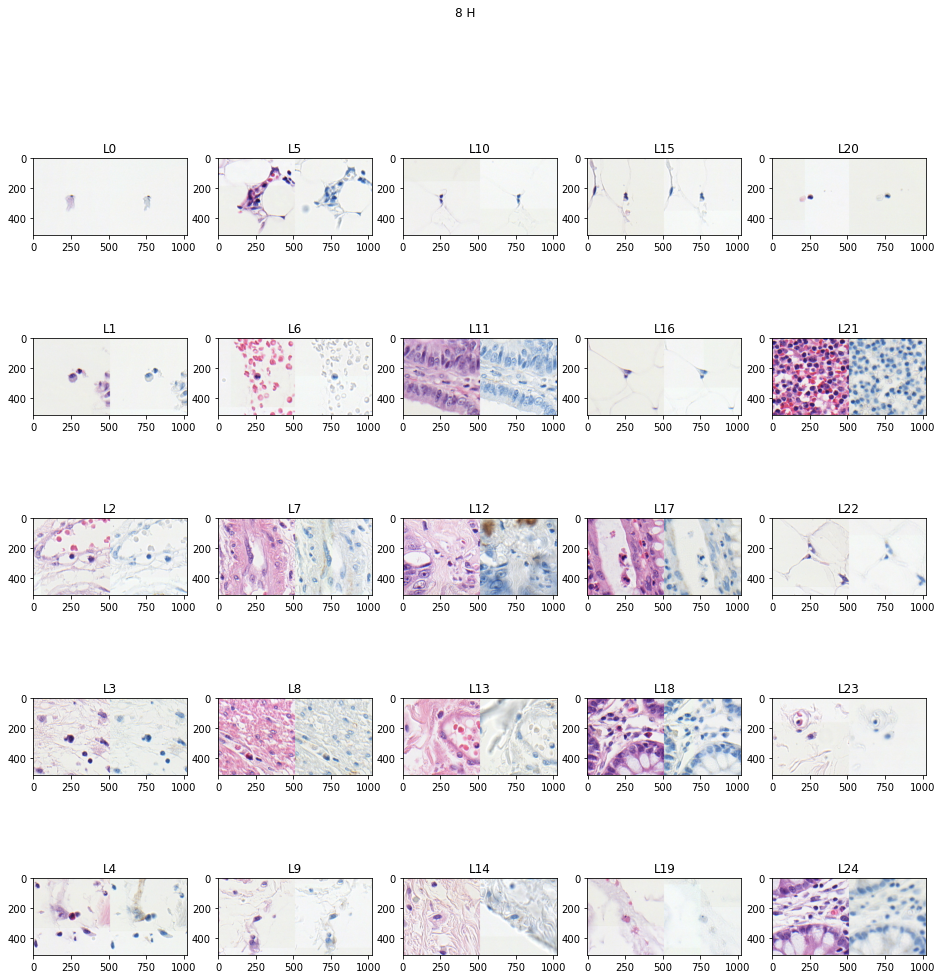

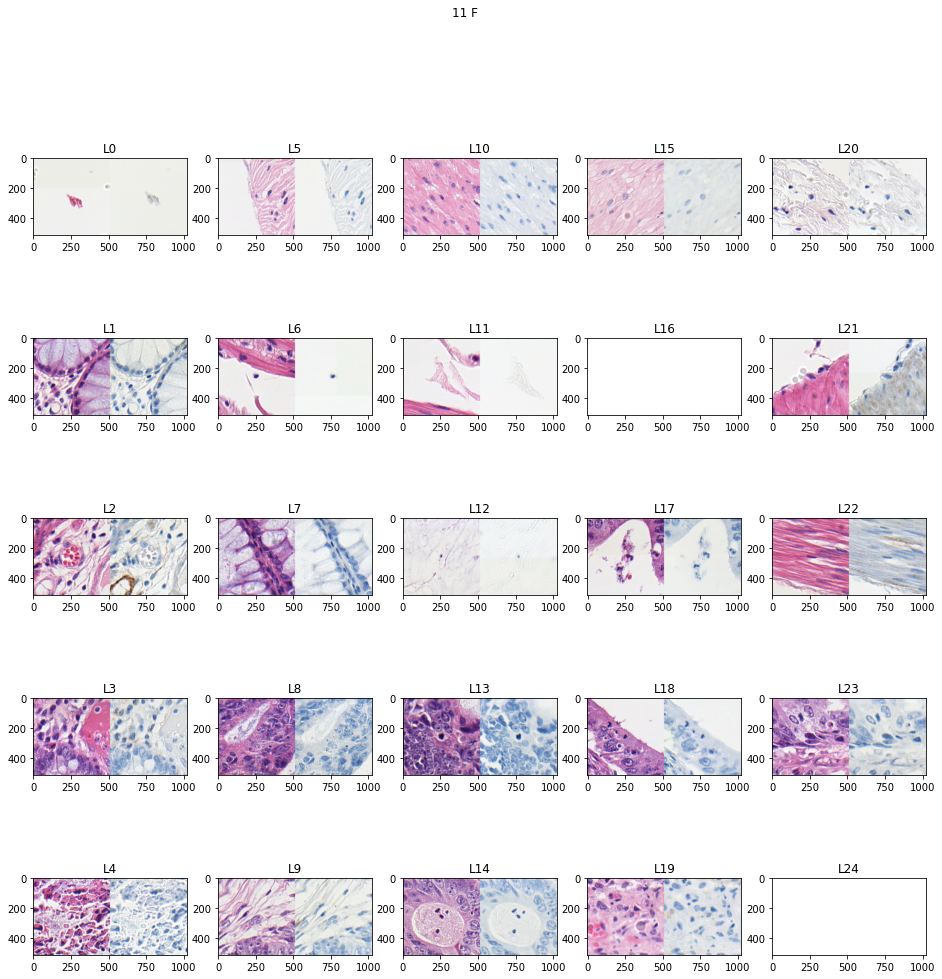

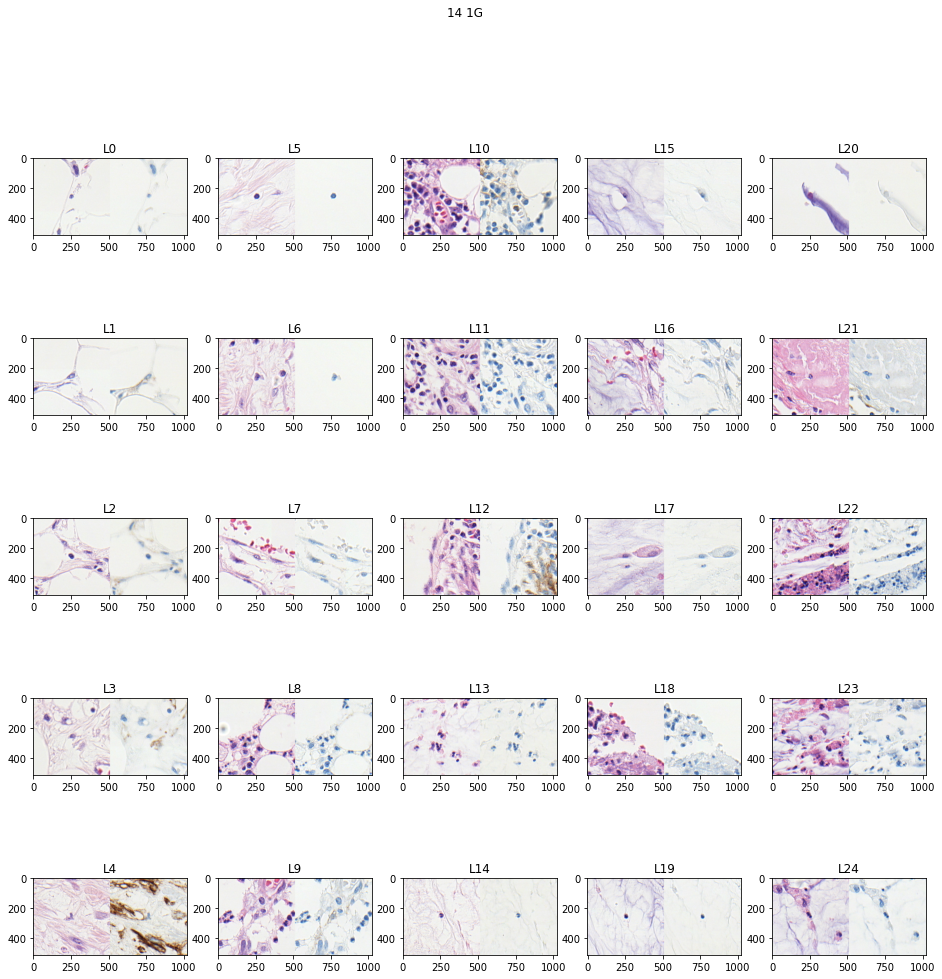

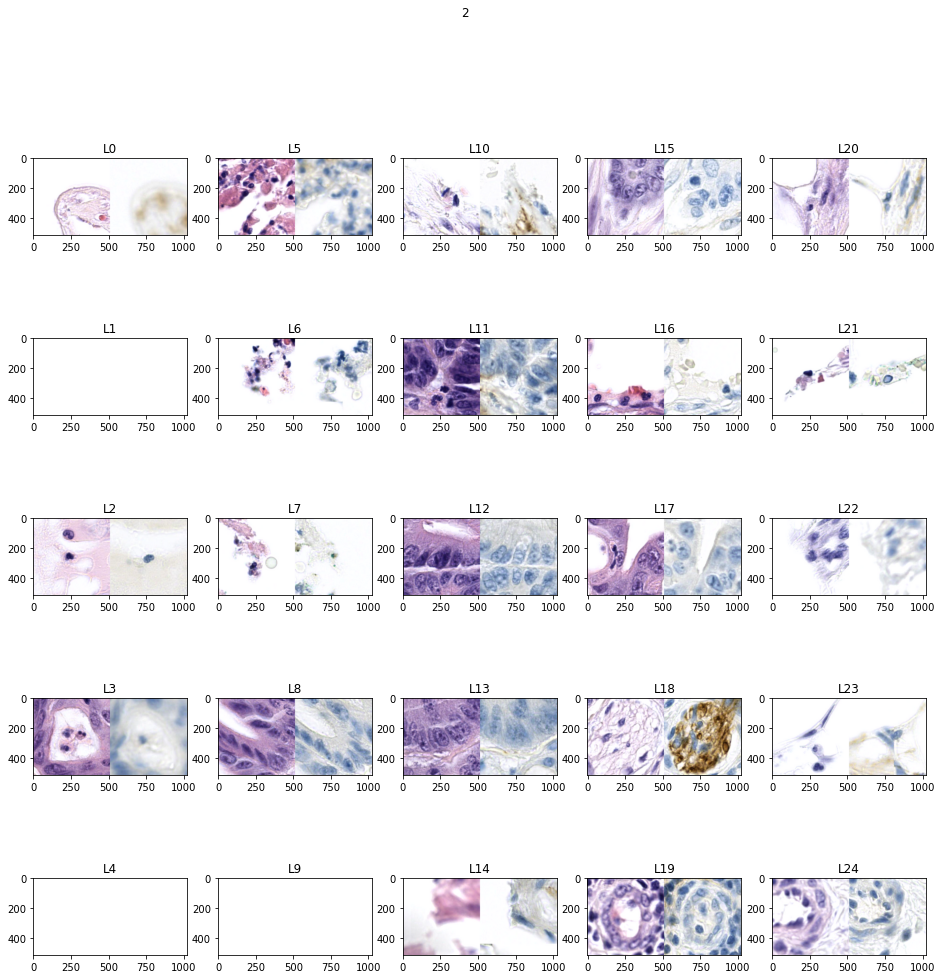

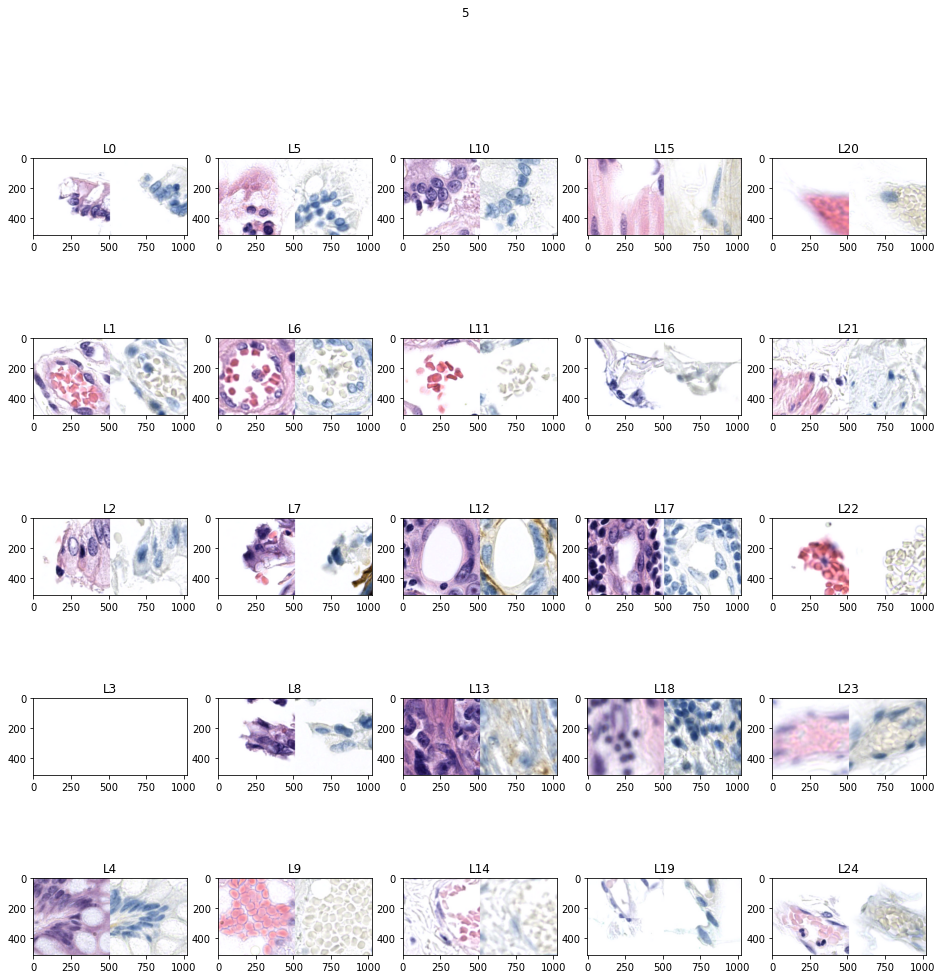

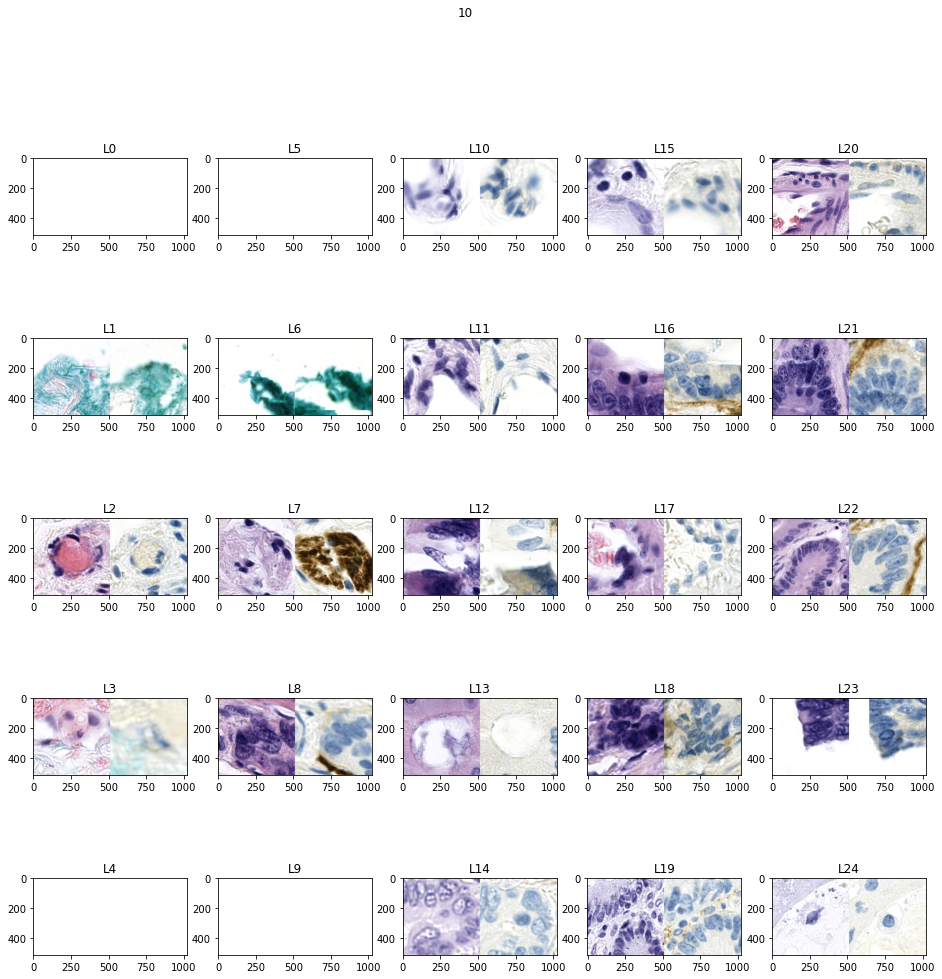

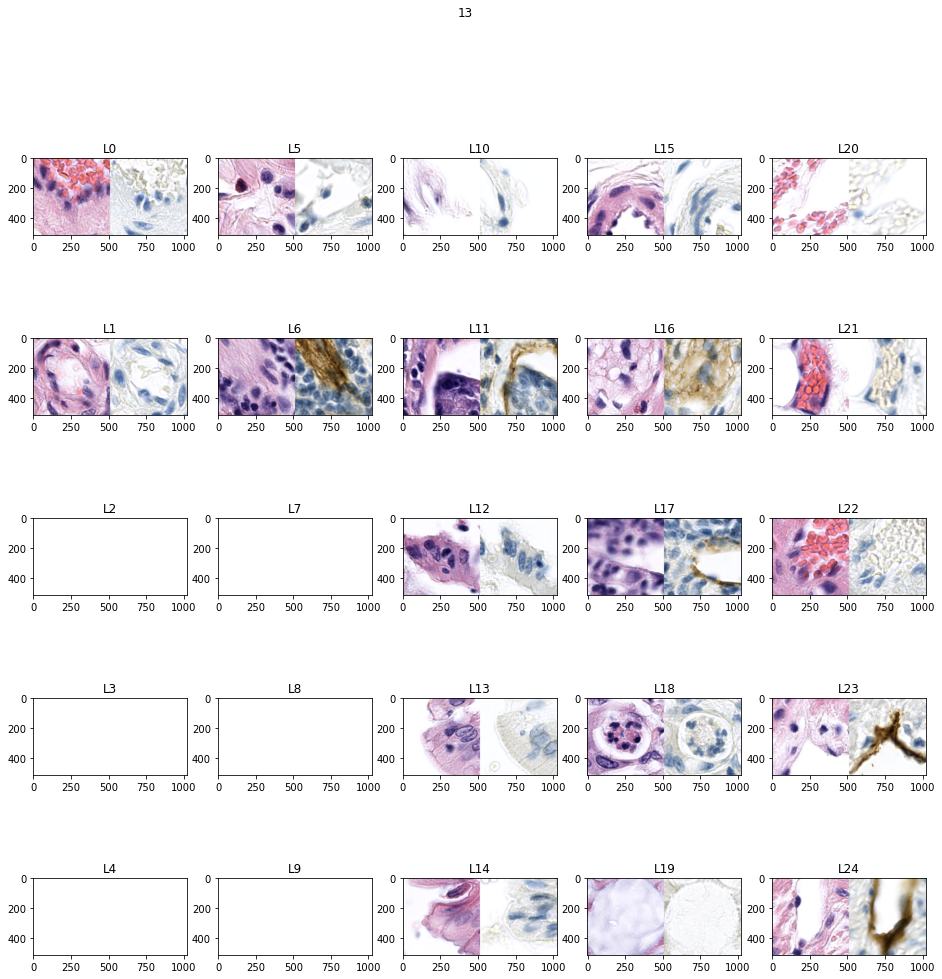

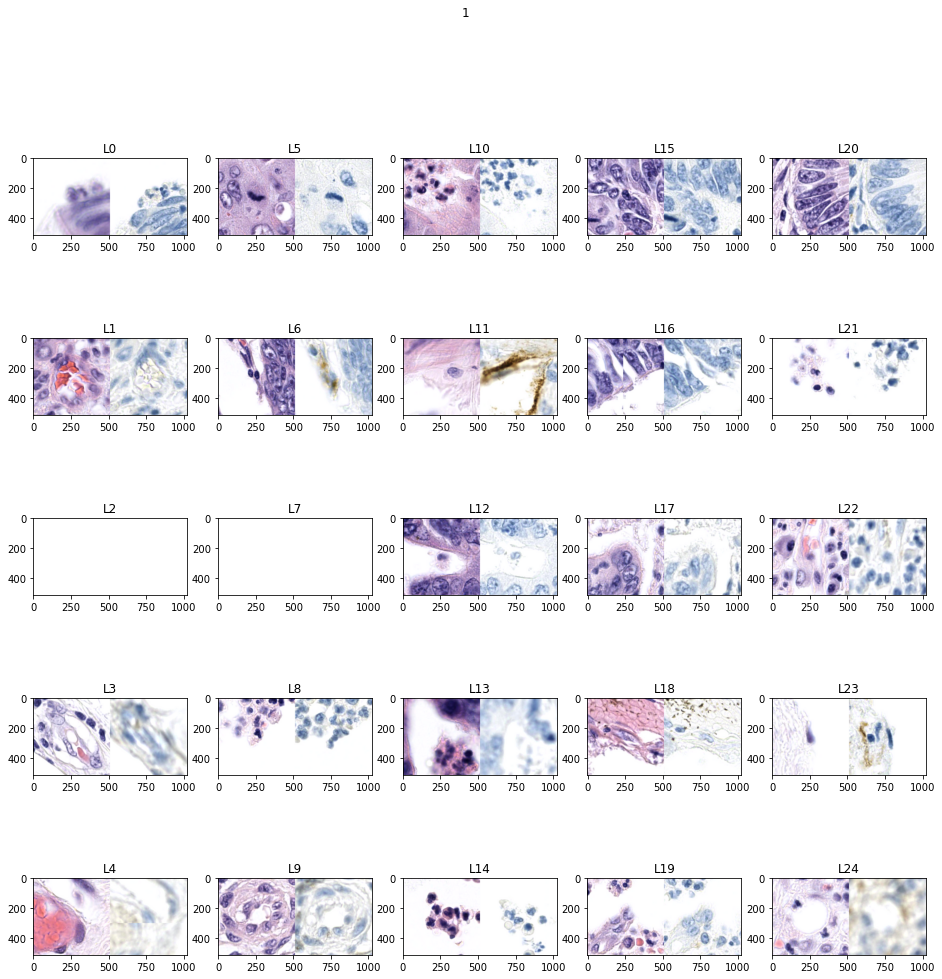

In [13]:
figsize = (16, 16)
patch_size, anno_offset = 512, 64

for image_type in gt_annotations["image_type"].unique():
    
    patient_ids = gt_annotations[gt_annotations["image_type"] == image_type]["patient_id"].unique()
    
    for patient_id in patient_ids:
        

        fig, axes = plt.subplots(ncols=5, nrows=5, figsize=figsize) 
        fig.suptitle(f'{patient_id}')       
        
        for type_name in coordinates.keys(): # gt_annotations[gt_annotations["patient_id"] == patient_id]["type_name"].unique():
            
            type_patch = np.ones(shape=(patch_size, patch_size*2, 3)).astype(np.uint8) * 255
                
            for idx, scanner in enumerate(gt_annotations["scanner"].unique()):

                df = gt_annotations[(gt_annotations["image_type"] == image_type) & 
                                    (gt_annotations["type_name"] == type_name) & 
                                     (gt_annotations["patient_id"] == patient_id) & 
                                     (gt_annotations["scanner"] == scanner)]

                                
                if df.empty == False:
                    annotation = df.iloc[0]
                    
                    temp_image_name = annotation.image_name.replace("40X", "X40")
                    slide = slide_list[temp_image_name]
                    
                    x_min, y_min = int(annotation.x1 - anno_offset), int(annotation.y1 - anno_offset)
                    x_max, y_max = int(annotation.x2 + anno_offset), int(annotation.y2 + anno_offset)
                    
                    w, h = x_max - x_min, y_max - y_min
                    anno_patch = np.array(slide.read_region(location=(x_min, y_min), level=0, size=(w, h)))[:, :, :3]
                    anno_patch = cv2.resize(anno_patch, (patch_size,patch_size))
                    
                    if idx == 0: type_patch[:patch_size, :patch_size] = anno_patch
                    if idx == 1: type_patch[:patch_size, patch_size:] = anno_patch
                    if idx == 2: type_patch[patch_size:, :patch_size] = anno_patch
                    if idx == 3: type_patch[patch_size:, patch_size:] = anno_patch
            
            ax = axes[coordinates[type_name]]
            ax.imshow(type_patch)
            
            ax.set_title(f"{type_name}")

        plt.savefig(f'C:/Users/c.marzahl/Documents/MICCAI_2021/GT_Patches/{image_type}_{patient_id}.pdf')
        plt.show()